# Creating subtables for the cleaned sample#

- the goal of this notebook is to show how we create the various sample tables from the clean_kitchen_sink.fits table
- the main program is **write_subtables.py**


- a major goal is to match the CO table with the mastertable
  - GL wants to do this using NED names, but this is complicated
  - for example, for one galaxy, the hyperleda name points to a different galaxy in NED
  - in another example, SHOC206b - the CO file is pointing to the second of a double nucleus in a galaxy, whereas the mastertable includes SHOC206a (this is the source in NSA, HL, etc)
  - so as usual, what seemed to be a simple task has stretched on for weeks...

## Cutting Catalog to Retain North Galaxies Only ##

2020-Apr-07

- decided in telecon today to keep north galaxies only for now
- need to redo matching because I sorted clean_kitchen.fits by DEC so that we have continuous VFID numbers in the north.
- need to rematch to:
  - z0MGS
  - 2MASS
  - extinction
  - legacy
- updating write_subtables.py to cut catalogs



In [145]:
from astropy.io import fits, ascii
from matplotlib import pyplot as plt
from astropy.table import Table
import os
import numpy as np
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
import sys
sys.path.append('/home/rfinn/github/APPSS/')
from a100sdss import colormass

In [4]:
def calc_offset(ra1, dec1, ra2, dec2):
    d = np.sqrt((ra2-ra1)**2 + (dec2-dec1)**2)*3600
    print('d in arcsec = {:.1f}'.format(d))

# Challenge: match CO by name rather than position ##
- this would be easy, except the NED names in the CO file are not the exact same as what NED considers the NED name.
- for example:  for an NGC galaxy, NED would have a space between the NGC and number

OPTIONS:
- could look up NED name for each galaxy in the CO table
- then match the real NED names to NEDname column in the master table
- this might be the most efficient.
- need to change UGC8656 to UGC8656 NOTES01 

# Solution: Fixing NED names in the CO Catalog #

- the CO catalog has NED names, but not in the exact format that NED uses
- running a ned query for each galaxy to get the right name
- then appending a column to CO mastertable called NEDname
- write new table 
  - outfile = homedir+'/github/Virgo/tables/CO-MasterFile-2018Feb16-fixedNEDnames.fits'
  
  

In [ ]:
%run ~/github/Virgo/programs/fix_CO_NEDname.py

## Checking Precision of RA and DEC values ##

- it seems like some of the values were truncated.
- Dustin Lang mentioned this when he matched to unWISE
- want to make sure they are ok

In [5]:
os.chdir('/home/rfinn/research/Virgo/supersample/')
cleancat = fits.getdata('vf_clean_sample.fits')

In [3]:
cleancat['RA']

array([185.86877, 182.208  , 145.94466, ..., 169.26881, 157.98427,
       158.10371], dtype=float32)

RA appears to preserve the significan digits in the table, but not when displayed in topcat.

# Matching to CO table #

- added method in write_subtables.py
  - get_CO
  - creates vf_co.fits

In [170]:
os.chdir('/home/rfinn/research/Virgo/supersample/')
%run ~/github/Virgo/programs/write_subtables.py --north

all CO sources have been matched. CONGRATULATIONS!!!!!!!
number of galaxies with CO matches =  227
number of duplicates =  1
CO sources that are matched to multiple galaxies in the mastertable:
NED_name
--------
      --
number of duplicates =  10
Halpha sources that are listed multiple times in the halpha file:
  VFID  
--------
VFID2060
VFID2076
VFID2080
VFID2089
VFID2095
VFID2136
VFID2141
VFID2145
VFID2154
VFID2157
(array([3]),)
(array([72]),)
(array([71]),)
(array([69]),)
(array([1]),)
(array([70]),)
(array([89]),)
(array([2]),)
(array([2]),)
(array([89]),)
(array([66]),)
number of lines in ha file after deleting rows =  100
number of columns after removing cols =  224
calculating snr
setting HAflag
writing hafile
finished writing hafile
number of galaxies with D25 measurement = 5638 (0.82%)
number of galaxies using NSA V1 Petro TH90 = 569 (0.08%)
number of galaxies using NSA V1 Petro TH90 = 62 (0.01%)
number of galaxies using A100 sdss Petro TH90 = 262 (0.04%)
number of galaxies w

<Figure size 432x288 with 0 Axes>

In [26]:
c.get_CO()

all CO sources have been matched. CONGRATULATIONS!!!!!!!
number of galaxies with CO matches =  227
number of duplicates =  1
CO sources that are matched to multiple galaxies in the mastertable:
NED_name
--------
      --


# Fixed Error: Needed to update indices of AGC sources in clean_kitchen_sink.py after adding NSA v0 #

These are old notes.  I'm leaving them in case they are useful.

- need to find the original id # in the kitchen_sink table so I can check the cutout
- opened smart_kitchen_sink_v2.fits in topcat, and sorted first by objname - but AGC source is not in this file
- it must be added when I match to A100.
  - problem - both sources have A100 flag = True, but HL = UGC08290 has not data entries in the A100 columns. UGH!!!
  - need to remember how I add A100 sources in clean_kitchen_sink.py
  - I also moved the NED query to its own program - get_NEDname.py.  This will be run separately after clean_kitchen_sink.py.  The output from get_NEDname.py is **vf_clean_sample_wNEDname.fits**.
  
- need to get index in catalog, then galnumber for that index.  do this BEFORE sorting by RA.  The galnumber will correspond to the number of the galaxy in the 10k that we reviewed by eye.
- I needed to update ID numbers in the clean_kitchen_sink - clean_new_a100 after adding NSA v2.  I did this on 5/15/20, and will now move on to solving for NED ids.

# Matching to NED sources #
- moved this to a different program
- it's run in get-NEDname notebook

## Before adding nsa_v0_1_2 ##

- galaxies with NED names (from query) that are significantly different from NED name in CO file

In [ ]:
%run ~/github/Virgo/programs/write_subtables.py
c.get_CO()

In [54]:
n1 = c.cotable['NEDname'][c.coflag]
n2 = c.cotable['NED_name'][c.coflag]
for i in range(sum(c.coflag)):
    if (n2[i][0:2] == n1[i][0:2]) & (n2[i][-2:] == n1[i][-2:]):
        continue
    else:
        print(n1[i], n2[i])

WISEA J150535.77+590537.2 ASK110438
MCG +08-25-006 PGC47274
MCG +08-16-005 SHOC206b
UGC8656 NOTES01 UGC8656
SDSS J134944.34+395905.1 NGC5313
WISEA J135224.88+393327.3 ASK322610
UGC 08919 NOTES01 ARK435
WISEA J113844.05+334817.2 UGC6610
2MASX J09512804+3256337 UGC5287
FBQS J085533.2+311242 PGC25063
SDSS J090024.12+253653.0 UGC4722
KUG 1209+203 PGC38859
SDSS J142004.36+035933.8 NGC5560
SDSS J150629.16+013620.9 NGC5846


| n | VF Table NEDname| CO Table NEDname| OK? | Explanation |
|---|----------|----------|-------------|----|
|1|WISEA J150535.77+590537.2| ASK110438| Y | NED says these are the same; VF name is official |
|2|MCG +08-25-006| PGC47274|Y | NED says these are the same; VF name is official |
|3|MCG +08-16-005| SHOC206b|N | NED says MCG is SHOC 206a, SHOC 206b is not in VF catalog|
|4|UGC8656 NOTES01| UGC8656|Y | this is named wrong in CO table; still need CO obs of UGC8656 |
|5|SDSS J134944.34+395905.1| NGC5313 | N | NED says NGC5313 is SDSS J134944.34+395905.2
|6|WISEA J135224.88+393327.3 |ASK322610|
|7|UGC 08919 NOTES01| ARK435|
|8|WISEA J113844.05+334817.2 |UGC6610|
|9|2MASX J09512804+3256337| UGC5287|
|10|FBQS J085533.2+311242 |PGC25063|
|11|SDSS J090024.12+253653.0| UGC4722|
|12|KUG 1209+203 |PGC38859|
|13|SDSS J142004.36+035933.8 |NGC5560|
|14|SDSS J150629.16+013620.9| NGC5846|


## Looking at mismatches more closely ##

|Pair|Object | NED Coords | offset (arcsec)| Conclusion | 
|--|-------|--------|----------|---|
|1 |SHOC206a=MCG +08-16-005 | RA/Dec Equatorial (J2000.0)	126.825060	46.032613| 5.8 | same galaxy? |
||SHOC206b   | RA/Dec Equatorial (J2000.0)	126.825303	46.034192|
|||||||
|2 |  NGC5313 = SDSS J134944.34+395905.2 | 207.434750	39.984778 |0.1 | same galaxy |
| | SDSS J134944.34+395905.1 |207.434766, 39.984776 |

## Conclusions ##
- seems like a problem when matching the main catalog to the NED catalog
- maybe there are multiple matches with/10-15 arcsec(whatever we used for max offset), and we are choosing the wrong one.


## After adding nsa_v0_1_2 ##

- galaxies with NED names (from query) that are significantly different from NED name in CO file


In [43]:
n1 = c.cotable['NEDname'][c.coflag]
n2 = c.cotable['NED_name'][c.coflag]
for i in range(sum(c.coflag)):
    if (n2[i][0:2] == n1[i][0:2]) & (n2[i][-2:] == n1[i][-2:]):
        continue
    else:
        print(n1[i], n2[i])

FBQS J085533.2+311242 PGC25063
KUG 1209+203 PGC38859
MCG +08-25-006 PGC47274
UGC 08919 NOTES01 ARK435
WISEA J135224.88+393327.3 ASK322610


## Write out subtables ##

- rewriting subtables after CO Ned names are fixed

CO sources with no match in mastertable:
         NEDname           NED_name
------------------------- ---------
                 NGC 2793   NGC2793
                SHOC 206b  SHOC206b
        UGC 08656 NOTES01   UGC8656
                UGC 09348   UGC9348
WISEA J150535.77+590537.2 ASK110438
number of galaxies with CO matches =  222


<Figure size 432x288 with 0 Axes>

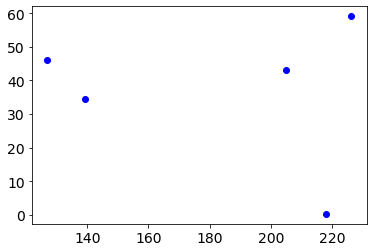

In [7]:
%run ~/github/Virgo/programs/write_subtables.py
c.get_CO()

## After including nsa_v0_1_2 ##

- 4 CO sources with no match in mastertable

In [1]:
%run ~/github/Virgo/programs/write_subtables.py
c.get_CO()

CO sources with no match in mastertable:
         NEDname           NED_name
------------------------- ---------
                SHOC 206b  SHOC206b
        UGC 08656 NOTES01   UGC8656
                UGC 09348   UGC9348
WISEA J150535.77+590537.2 ASK110438
number of galaxies with CO matches =  225


## After Adding NSA v0_1_2, still have 4 CO sources that are not in mastertable ##

|         NEDname         | NOTES | OTHER |
|-------------------------|--------| ------|
|                SHOC 206b| NSA 015877; this is the same source as SHOC 206a 
|        UGC 08656 NOTES01| LEDA 214137 |
|                UGC 09348| in NSA 002473 (NSA version 2 vr = 27000!), SDSS, PGC 051957; should be in cat|
|WISEA J150535.77+590537.2| NSA 019809 (in v2, ZDIST=.0459; v1, ZDIST=.008867)|


### SHOC 206b ###

-  NSA 015877; this is the same source as SHOC 206a
- http://nsatlas.org/getAtlas.html?search=nsaid&nsaID=015877&submit_form=Submit 
- The NSA image shows that there is a double nucleus, so "b" is pointing to the southern nucleus and "a" is more central.  I'm assuming that the CO beam is the same.
- The NSA photometry is for the combined source
- The official NEDname of SHOC206a is MCG +08-16-005
- These should be merged in our catalog
- could reset the name in the CO table to be MCG +08-16-005, and then the matching should proceed ok.

### UGC 08656 NOTES01 ###
- This is the companion source to UGC 08656
- this was accidentally observed instead of the main source
- no cross id in NSA or AGC.  
- https://ned.ipac.caltech.edu/byname?objname=UGC%2008656%20NOTES01&hconst=67.8&omegam=0.308&omegav=0.692&wmap=4&corr_z=1

### UGC 09348 ###

- NSA 002473
- http://nsatlas.org/getAtlas.html?search=nsaid&nsaID=2473&submit_form=Submit
- this is in the vf_clean_sample.fits
  - NEDname is NGC 5658 in our table, but this is not the NED name of UGC 9348
- NED link for UGC 09348: https://ned.ipac.caltech.edu/byname?objname=UGC%2009348&hconst=67.8&omegam=0.308&omegav=0.692&wmap=4&corr_z=1
- NED link for NGC 5658: https://ned.ipac.caltech.edu/byname?objname=NGC%205658&hconst=67.8&omegam=0.308&omegav=0.692&wmap=4&corr_z=1

| OBJECT | RA | DEC | Z | AKA |
|--------|----|-----|----|---|
| UGC 09348 | 14h32m28.507s/ 218.118779| +00d17m38.43s/	0.294008 | 1672 | NSA 002473, PGC 051957 |
| NGC 5658 | 14h31m55.288s/	217.980366| -00d22m02.27s/-0.367298 | no z | WISEA J143155.28-002202.4 |

- OK, this one is really odd.  Hyperleda gives the UGC09348 coordinates for NGC5658!
  - http://leda.univ-lyon1.fr/ledacat.cgi?o=NGC%205658
  - hyperleda says the alternate name is UGC09348!  but NED has completely different coordinates for these two.  Which is correct???
  - both surveys agree on UGC09348, so best solution is to change Hyperleda name to UGC 09348
  
### WISEA J150535.77+590537.2 ###

- NSA 019809 - this is in vf_clean_sample.fits
- in our catalog, the NEDname of NSA source is 2MASX J13593307+3240534
- HL name in our catalog is PGC2586382

| OBJECT | RA | DEC | Z | AKA |
|--------|----|-----|----|---|
|  WISEA J150535.77+590537.2 | 15h05m35.727s, +59d05m37.56s | 	226.398865, 59.093766 | 2606 | NSA 019809 |

| MASX J13593307+3240534  | 13h59m33.099s, +32d40m53.00s | 	209.887914, 32.681388 |     | NSA 094608 |

| PGC2586382 | 	J150535.74+590537.7 | 

- so somehow we got the wrong NEDname for this guy.
- hmmm - looks like a lot of the ned names
- going to gather ned names again, and also save the RA and DEC.  then I can check the RA and DEC against the values in our catalog to make sure its correct.

I also just found an issue in how I was combining the RA and DEC values in clean_kitchen_sink.py, so I need to rerun this as well.

# All CO sources are now in the mastertable #

- 5 galaxies in CO table are not in mastertable.
- Gianluca said he removed some sources as well because they were too distant.
- going to check the sources that I can't match against his list
- he emailed me a list on Friday 4/17: 


|         NEDname         | NOTES |
|-------------------------|--------|
|                 NGC 2793| NSA 135797 (not in version 2 of NSA!, in version 1), PG 026189|
|                SHOC 206b| NSA 015877 (in v2, but ZDIST = .13!; v1 ZDIST=.0077) | 
|        UGC 08656 NOTES01| LEDA 214137 |
|                UGC 09348| in NSA 002473 (NSA version 2 vr = 27000!), SDSS, PGC 051957; should be in cat|
|WISEA J150535.77+590537.2| NSA 019809 (in v2, ZDIST=.0459; v1, ZDIST=.008867)|




# Steer+17 Table with Redshift-independent distances #

- Downloaded this from NED webpage
- http://ned.ipac.caltech.edu/Library/Distances/
- did a first matching in topcat, based on NED name
  - best match, symmetric, all from 1
  - found 2411 pairs
  - saved as fits-basic
  - ~/research/Virgo/tables/vf-steer17.fits
  
### Need to use Gianluca's catalog instead. ###

- he has combined independent distance measurements for each galaxy (using median), and scaled to same value of H0
  - /home/rfinn/research/Virgo/ancil-tables/Steer2017_cat_Virgo_field_H0_74_0.fits
  
- editing **write_subtables.py** to do the matching
  - subroutine match_steer17
  
- match by NEDname


In [9]:
steercat = '/home/rfinn/research/Virgo/ancil-tables/Steer2017_cat_Virgo_field_H0_74_0.fits'
steer = Table(fits.getdata(steercat))

In [10]:
steer

Type_NED,Dall_err,decNED,Dmedian,Num. D Measures,NEDname,raNED,zNED,Dmedian_Steer,Dmean,Dmin,Dall,Dmax,Dmean_Steer,Galaxy ID
str6,str755,float64,float64,int64,str29,float64,float64,float64,float64,float64,str825,float64,float64,str30
G,2.72,48.30375,73.740155000527,1,2MASX J07084401+4818132,107.18337,0.020731,78.1,73.740155000527,73.740155000527,73.74,73.740155000527,78.1,2MASX J07084401+4818132
G,3.66,48.8315,79.37871170573928,1,2MASX J07085345+4849532,107.22275,0.020928,84.1,79.37871170573928,79.37871170573928,79.38,79.37871170573928,84.1,2MASX J07085345+4849532
G,2.86-5.98-6.32,-5.42792,31.058390185656297,3,2MASX J07093459-0525404,107.39413,0.005724,30.9,31.04190514854785,30.176388999973135,31.06-30.18-31.89,31.89093626001412,30.733333333333334,2MASX J07093459-0525404
G,-4841.16,-22.04481,10.512452492215363,1,2MASX J07300813-2201060,112.51767,0.002592,11.1,10.512452492215363,10.512452492215363,10.51,10.512452492215363,11.1,2MASX J07300813-2201060
G,2.75-5.88-8.09-8.35-8.45,-30.11219,39.057464450683725,5,2MASX J07412825-3006436,115.36763,0.007032,41.4,35.07030918761221,25.924121376610223,25.92-31.89-39.06-39.42-39.06,39.418858719690135,37.14,2MASX J07412825-3006436
G,10.85,13.43354,71.40095920428249,1,2MASX J07593778+1326003,119.90754,0.014935,75.6,71.40095920428249,71.40095920428249,71.40,71.40095920428249,75.6,2MASX J07593778+1326003
G,12.83,-9.90174,58.036878524628676,1,2MASX J08001030-0954062,120.0429,0.022385,61.3,58.036878524628676,58.036878524628676,58.04,58.036878524628676,61.3,2MASX J08001030-0954062
G,13.42,11.31945,63.34379022335643,1,2MASX J08002096+1119098,120.08741,0.01491,67.0,63.34379022335643,63.34379022335643,63.34,63.34379022335643,67.0,2MASX J08002096+1119098
G,3.41-6.12-13.69-14.07,21.41867,68.19096704682063,4,2MASX J08235222+2125079,125.96771,0.016995,69.15,68.46261954412418,66.4016607779013,67.25-66.40-69.13-71.07,71.06688330495413,68.92499999999998,2MASX J08235222+2125079


# Matching to IPAC catalogs #

- run the method in write_subtables
- then upload coordinate file to irsa
- this creates coords_for_z0MGS.txt - an ipac table - in research/Virgo/tables/
- https://irsa.ipac.caltech.edu/cgi-bin/Gator/nph-dd
  - z0MGS DR1 (first catalog w/more sources)
  - one-to-one match
  - standard form
  - then download as ipac table

# Need to keep North only - write another method


In [29]:
%run ~/github/Virgo/programs/write_subtables.py
c.catalog_for_z0MGS()

In [128]:
%run ~/github/Virgo/programs/write_subtables.py --north

/home/rfinn/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


all CO sources have been matched. CONGRATULATIONS!!!!!!!
number of galaxies with CO matches =  227
number of duplicates =  1
CO sources that are matched to multiple galaxies in the mastertable:
NED_name
--------
      --
number of duplicates =  0
Halpha sources that are listed multiple times in the halpha file:
NSA ID
------
Halpha table lengths
6860 294 6860
Number in sample =  6860
Number with CO data =  227
Number with A100 data = 2341 (0.341)
Number with z0MGS matches = 2323 (0.339)
Number with steer17 matches = 1785 (0.260)
Number with unwise matches = 6260 (0.913)
Number with unWISE and NSA = 5332 (0.777)
CO SOURCES
	Number of CO sources in z0MGS = 221 (0.97)
	Number of CO sources in Steer = 162 (0.71)
	Number of CO sources in z0MGS+Steer = 162 (0.71)
	Number of CO sources with unWISE and NSA = 218 (0.96)


In [124]:
c.hatable

VFID,RA,DEC,vr,objname,NSAID,NSAIDV0,AGC,NEDname,HLflag,NSAflag,NSAV0flag,A100flag,NED,RA_ha,DEC_ha,Vr,CO,HI,Halpha,Pointing,Date Obs,Date Obs2,Alt Point,Date Obs3,Filament,Group,Telescope,filter,Dithers,R expt (s),Halpha expt (s),R expt tot,Halpha exp tot,R FWHM (iraf),R FWHM,Ha4 FWHM (iraf),Ha4 FWHM,haflag
str8,float32,float32,float32,str28,int32,int64,int64,str30,bool,bool,bool,bool,str12,float64,float64,float64,int64,int64,int64,str14,str10,str10,str6,str10,int64,int64,str9,str8,int64,int64,str13,int64,int64,float64,float64,float64,float64,bool
VFID0000,185.86877,74.95225,1418.8,NGC4363,0,0,0,NGC 4363,True,False,False,False,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,False
VFID0001,182.208,74.904274,1331.5,NGC4133,0,0,0,NGC 4133,True,False,False,False,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,False
VFID0002,145.94466,74.85958,3049.4,NGC2977,0,0,0,NGC 2977,True,False,False,False,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,False
VFID0003,185.57309,74.83839,1833.0,PGC040048,0,0,0,CGCG 352-030,True,False,False,False,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,False
VFID0004,182.82774,74.80822,1683.0,UGC07189,0,0,0,UGC 07189,True,False,False,False,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,False
VFID0005,173.13419,74.62754,1920.1,NGC3752,0,0,0,NGC 3752,True,False,False,False,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,False
VFID0006,121.91241,74.58463,2333.0,UGC04202,0,0,0,UGC 04202,True,False,False,False,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,False
VFID0007,118.2363,74.57653,2346.0,PGC022064,0,0,0,KUG 0746+747,True,False,False,False,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,False
VFID0008,274.94318,74.56839,1484.5,NGC6643,0,0,0,NGC 6643,True,False,False,False,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,--,False


# Getting Size Measurement for Each Galaxy #


- I use hyperleda D25 if it exists (5638/6860, or 85% of sample)
  - the website says this is in units of 0.1 arcmin
  - so I divide by 10, and then x60 convert to arcsec, and the /2 to get radius
- If no D25, I then check if galaxy is in NSA v1 (569/6860, or 8%)
  - if yes, I use 1.3x the Petrosian TH90
  - I eyeballed the scale factor by comparing D25 with PETRO_TH90
- If galaxy doesn't have D25 and is not in NSA v1, I check NSA v0 (62/6860, or 1%)
  - I use the same scaling for petrosian radius
- If galaxy doesn't have D25 and isn't in either version of the NSA, I check if it's in A100 (308/6860, or 4%)
  - if yes, I use the SDSS petro R90
  - I scale this by a factor of 1.4, which I again determine empirically by comparing with D25.
- For those with none of these sizes available, I set the radius to 100 arcsec



In [1]:
%run ~/github/Virgo/programs/write_subtables.py --north

Running on Rose's computer


/home/rfinn/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


all CO sources have been matched. CONGRATULATIONS!!!!!!!
number of galaxies with CO matches =  227
number of duplicates =  1
CO sources that are matched to multiple galaxies in the mastertable:
NED_name
--------
      --
number of duplicates =  10
Halpha sources that are listed multiple times in the halpha file:
  VFID  
--------
VFID2060
VFID2076
VFID2080
VFID2089
VFID2095
VFID2136
VFID2141
VFID2145
VFID2154
VFID2157
(array([3]),)
(array([72]),)
(array([71]),)
(array([69]),)
(array([1]),)
(array([70]),)
(array([89]),)
(array([2]),)
(array([2]),)
(array([89]),)
(array([66]),)
number of lines in ha file after deleting rows =  100
number of columns after removing cols =  224
calculating snr


/home/rfinn/github/Virgo/programs/write_subtables.py:582: RuntimeWarning: invalid value encountered in true_divide
  self.haflag = ((self.hatable['HF_R24']/self.hatable['HF_R24_ERR']) > 1.)
/home/rfinn/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


setting HAflag
writing hafile
finished writing hafile
number of galaxies with D25 measurement = 5638 (0.82%)
number of galaxies using NSA V1 Petro TH90 = 569 (0.08%)
number of galaxies using NSA V1 Petro TH90 = 62 (0.01%)
number of galaxies using A100 sdss Petro TH90 = 262 (0.04%)
number of galaxies with no size measurement = 329 (0.05%)
CALCULATING SFRS


/home/rfinn/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


1.1938664705522868


/home/rfinn/github/Virgo/programs/write_subtables.py:309: RuntimeWarning: divide by zero encountered in log10
  self.logMHI = np.log10(2.36e5*self.cat['HIflux'])+2*np.log10(self.cat['Dist']) #Dist^2
/home/rfinn/github/Virgo/programs/write_subtables.py:335: RuntimeWarning: divide by zero encountered in log10
  logD25kpc=np.log10(D25obskpc.value) + 0.35*np.log10(self.cat['expAB_r'])
/home/rfinn/github/Virgo/programs/write_subtables.py:355: RuntimeWarning: invalid value encountered in subtract
  self.HIdef_bos = logh2MHIref - self.logMHI


Number in sample =  6860
Number with CO data =  227
Number with A100 data = 2341 (0.341)
Number with z0MGS matches = 2323 (0.339)
Number with steer17 matches = 1785 (0.260)
Number with unwise matches = 6260 (0.913)
Number with unWISE and NSA = 5332 (0.777)
CO SOURCES
	Number of CO sources in z0MGS = 221 (0.97)
	Number of CO sources in Steer = 162 (0.71)
	Number of CO sources in z0MGS+Steer = 162 (0.71)
	Number of CO sources with unWISE and NSA = 218 (0.96)


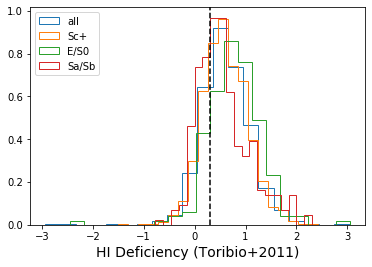

In [160]:
# check HI deficiency

plt.figure()
t = plt.hist(c.HIdef[c.HIdef_flag],bins=20,histtype='step',label='all',normed=True)
flag = c.HIdef_flag & (c.cat['t'] > 5)
t = plt.hist(c.HIdef[flag],bins=20,histtype='step', label='Sc+',normed=True)
flag = c.HIdef_flag & (c.cat['t'] <= 0)
t = plt.hist(c.HIdef[flag],bins=20,histtype='step',label='E/S0',normed=True)
flag = c.HIdef_flag & (c.cat['t'] <= 5)  & (c.cat['t'] > 0)
t = plt.hist(c.HIdef[flag],bins=20,histtype='step',label='Sa/Sb',normed=True)
plt.legend()
plt.xlabel("HI Deficiency (Toribio+2011)",fontsize=14)
plt.axvline(x=0.3,ls='--',c='k')

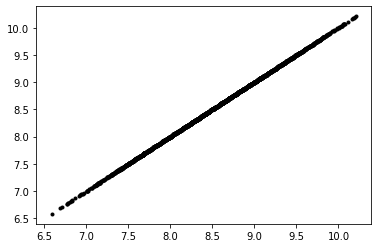

In [103]:
# plot my calc of HI mass vs a100 HI mass
plt.figure()
plt.plot(c.logMHI, c.cat['logMH'],'k.')
# looks good!!!

Text(0, 0.5, 'HI def Boselli')

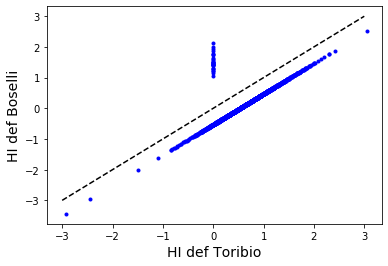

In [156]:
# plot my calc of HI mass vs a100 HI mass
plt.figure()
plt.plot(c.HIdef, c.HIdef_bos,'b.')
xl = np.linspace(-3,3,20)
plt.plot(xl,xl,'k--')
plt.xlabel('HI def Toribio',fontsize=14)
plt.ylabel('HI def Boselli',fontsize=14)

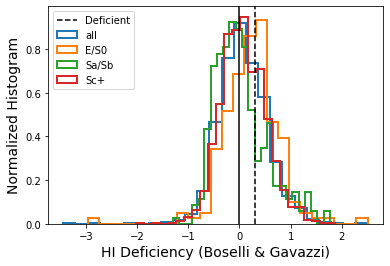

In [169]:
# histogram of Boselli HIdef

plt.figure()
nbin=25
t = plt.hist(c.HIdef_bos[c.HIdef_flag],bins=nbin,histtype='step',label='all',normed=True,lw=2)

flag = c.HIdef_flag & (c.cat['t'] <= 0)
t = plt.hist(c.HIdef_bos[flag],bins=nbin,histtype='step',label='E/S0',normed=True,lw=2)
flag = c.HIdef_flag & (c.cat['t'] <= 5)  & (c.cat['t'] > 0)
t = plt.hist(c.HIdef_bos[flag],bins=nbin,histtype='step',label='Sa/Sb',normed=True,lw=2)
flag = c.HIdef_flag & (c.cat['t'] > 5)
t = plt.hist(c.HIdef_bos[flag],bins=nbin,histtype='step', label='Sc+',normed=True,lw=2)


plt.xlabel("HI Deficiency (Boselli & Gavazzi)",fontsize=14)
plt.ylabel('Normalized Histogram',fontsize=14)
plt.axvline(x=0.3,ls='--',c='k',label='Deficient')
plt.axvline(x=0.,ls='-',c='k')
plt.legend()

In [172]:
# histogram of Boselli HIdef
rmax = 3.6
virgo_flag = (c.env['distSGY_Virgo']**2 + c.env['distSGZ_Virgo']**2+ c.env['distSGX_Virgo']**2) < rmax**2
print('number of cluster members = ',sum(virgo_flag))
filament_flag = (c.filmemb['filament']!='---') & (~virgo_flag)


plt.figure()
nbin=25
t = plt.hist(c.HIdef_bos[c.HIdef_flag],bins=nbin,histtype='step',label='all',normed=True,lw=2)

# virgo
flag = c.HIdef_flag & (virgo_flag)
t = plt.hist(c.HIdef_bos[flag],bins=nbin,histtype='step',label='Virgo',normed=True,lw=2)
flag = c.HIdef_flag & (filament_flag)
t = plt.hist(c.HIdef_bos[flag],bins=nbin,histtype='step',label='Filaments',normed=True,lw=2)
flag = c.HIdef_flag & (~virgo_flag & ~filament_flag)
t = plt.hist(c.HIdef_bos[flag],bins=nbin,histtype='step', label='Field',normed=True,lw=2)


plt.xlabel("HI Deficiency (Boselli & Gavazzi)",fontsize=14)
plt.ylabel('Normalized Histogram',fontsize=14)
plt.axvline(x=0.3,ls='--',c='k',label='Deficient')
plt.axvline(x=0.,ls='-',c='k')
plt.legend()

AttributeError: 'catalog' object has no attribute 'env'

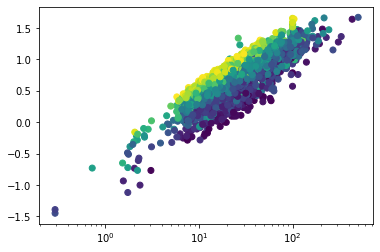

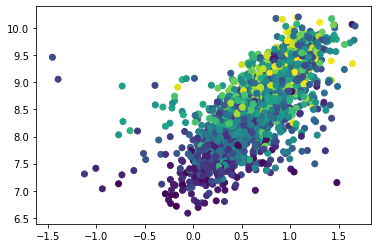

In [157]:
# histogram of D25 in kpc
plt.figure()
plt.scatter(c.radius,c.logD25kpc,c=c.cat['vr'])
plt.gca().set_xscale('log')

plt.figure()
plt.scatter(c.logD25kpc[c.HIdef_flag],c.logMHI[c.HIdef_flag],c=c.cat['vr'][c.HIdef_flag])
#c = np.polyfit(c.logD25kpc[c.HIdef_flag],c.logMHI[c.HIdef_flag],1)
#xl = np.linspace(1.5,4,20)
#yl = np.polyval(c,xl)
#plt.plot(xl,yl,'k--')

In [112]:
da=cosmo.angular_diameter_distance(.02)

In [118]:
help(cosmo.angular_diameter_distance)

Help on method angular_diameter_distance in module astropy.cosmology.core:

angular_diameter_distance(z) method of astropy.cosmology.core.FlatLambdaCDM instance
    Angular diameter distance in Mpc at a given redshift.
    
    This gives the proper (sometimes called 'physical') transverse
    distance corresponding to an angle of 1 radian for an object
    at redshift ``z``.
    
    Weinberg, 1972, pp 421-424; Weedman, 1986, pp 65-67; Peebles,
    1993, pp 325-327.
    
    Parameters
    ----------
    z : array-like
      Input redshifts.  Must be 1D or scalar.
    
    Returns
    -------
    d : `~astropy.units.Quantity`
      Angular diameter distance in Mpc at each input redshift.



In [66]:
flagNUV = c.cat['SERSIC_NMGY'][:,1] > 0.
flag22 = c.cat['w4_mag'] > 0

/home/rfinn/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:984: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


Text(0, 0.5, 'NUV+IR SFR')

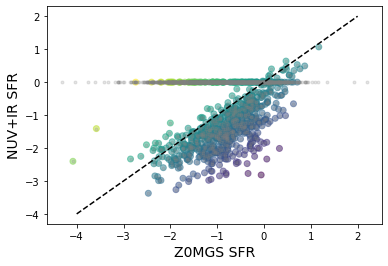

In [83]:
plt.figure()
residual = c.logSFR_NUVIR_KE - c.z0mgs_cat['logsfr']
plt.plot(c.z0mgs_cat['logsfr'],c.logSFR_NUVIR_KE,'k.',color='0.5',alpha=.2)
#plt.plot(c.z0mgs_cat['logsfr'][flagNUV],c.logSFR_NUVIR_KE[flagNUV],'k.',color='b',alpha=.2)
#plt.plot(c.z0mgs_cat['logsfr'][flag22],c.logSFR_NUVIR_KE[flag22],'k.',color='r',alpha=.2)
plt.scatter(c.z0mgs_cat['logsfr'][flag22],c.logSFR_NUVIR_KE[flag22],c=residual[flag22],alpha=.5)
xl = np.linspace(-4,2,20)
plt.plot(xl,xl,'k--')
plt.xlabel('Z0MGS SFR',fontsize=14)
plt.ylabel('NUV+IR SFR',fontsize=14)

plt.figure()
plt.scatter()

In [74]:
print(sum(flagNUV & flag22),sum(flag22),sum(flag22)/len(flag22))

1161 1575 0.22959183673469388


In [71]:
sum(c.z0mgsFlag)

2323

# Checking Size Measurements #

- JM said that some galaxies have nan for their size
  - these are AGC galaxies
  - so maybe the petro90 isn't getting pulled correctly?
- in addition, some have size = 0, or VERY small values
- fixed these
  - some A100 galaxies don't have sdss phot
  - set r = 100 arcsec for these
  - if more precision is important, we could query NED for some of these

# Running JM's group-finding code #

- downloaded his repository
- going to try to import from SGA-build-parent


In [75]:
%run ~/github/Virgo/programs/find_groups.py

Spheregrouping took......0.509 min
Found 6649 total groups, including:
  6516 groups with 1 member
  110 groups with 2 members
  21 group(s) with 3-5 members
  0 group(s) with 6-10 members
  2 group(s) with >10 members
Building a group catalog took 0.517 min


In [76]:
os.chdir('/home/rfinn/research/Virgo/tables-north/v0/')

In [78]:
gcat.write('vf_north_v0_groups.fits',format='fits',overwrite=True)

In [16]:
from astropy.coordinates import SkyCoord

In [17]:
c1 = SkyCoord(180,20,frame="icrs",unit="deg")
c2 = SkyCoord(183,24,frame="icrs",unit="deg")

In [19]:
dd = c1.separation(c2)
print(dd.deg)

4.871560171250968


# catalog statistics #

In [129]:
print('fraction with HL data = ',sum(maintab['HLflag'])/len(maintab))

NameError: name 'maintab' is not defined